# N-qubit GHZ distillation protocols

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sy
from numpy.linalg import multi_dot
from google.colab import files
from itertools import product
import functools as ft

%matplotlib inline

## Utilizing gate-decomposition of the unitary operations for arbitrary no. parties

In [47]:
# Define Pauli matrix sigma_0
sigma_0 = np.array([[1, 0], [0, 1]])

# Define |0X0| measurement matrix
M0 = np.outer([1, 0], np.conjugate([1, 0]))

# Define |1X1| measurement matrix
M1 = np.outer([0, 1], np.conjugate([0, 1]))

def make_measurement_matrix(N, mea='0'):
  # N Number of parties
  # nq Number of qubits
  # mea desired measurement result on ancillary qubits -> possible inputs: 0/1; default mea='0'
  nq = 2*N
  if mea=='0':
    matrices = [sigma_0 if i % 2 == 0 else M0 for i in range(nq)]
    result = ft.reduce(np.kron, matrices)
  elif mea=='1':
    matrices = [sigma_0 if i % 2 == 0 else M1 for i in range(nq)]
    result = ft.reduce(np.kron, matrices)
  return result

In [48]:
S0 = np.array([1, 0])
S1 = np.array([0, 1])

def make_GHZ(nq):
  # nq Number of qubits
  listS0 = [S0 for _ in range(nq)]
  listS1 = [S1 for _ in range(nq)]
  GHZ = ft.reduce(np.kron, listS0).flatten()/ np.sqrt(2) + ft.reduce(np.kron, listS1).flatten() / np.sqrt(2)
  return GHZ

def make_GHZl(nq, c):
  # nq Number of qubits
  listS0 = [S0 for _ in range(nq)]
  listS1 = [S1 for _ in range(nq)]
  GHZl = ft.reduce(np.kron, listS0).flatten() + c * ft.reduce(np.kron, listS1).flatten()
  return GHZl / np.linalg.norm(GHZl)

In [49]:
from scipy.sparse import csr_matrix

def make_rho_GHZ(rho):
  # Compute the outer product of GHZ and its conjugate
  return np.outer(rho, np.conjugate(rho))

# Convert the rho_GHZ to a sparse matrix
# rho_GHZ_sparse = csr_matrix(rho_GHZ)

In [50]:
#from scipy.sparse import identity

def make_noisy_rho(rho_GHZ, nq, lambda_val):
  ''' Calculate noisy initial density matrix'''
  # lambda_val noise strength
  d = 2**nq # dimension
  rho_noisy = (1 - lambda_val) * rho_GHZ + lambda_val / d * np.identity(d)
  return rho_noisy

In [51]:
#traceing out the ancillary qubits in non-transformed basis
def partial_trace_g(rho, N):
  ''' partial trace of rho(2^2n_x_2^2n), qubits: q0,q1,q2,q3,q4,q5,...qn-1
      tracing out last n/2 qubits, resulting in rho(2^n_x_2^n)
  '''
  # N number of ancillary qubit
  rho_traced = rho.reshape([2 for _ in range(2*2*N)])
  for i in range(N):
    rho_traced = np.trace(rho_traced, axis1=N, axis2=3*N-i)
  return rho_traced.reshape([2**N, 2**N])

In [52]:
# Define CNOT matrix - CNOT(index-of-control-qubit, index-of-target-qubit, number-of-parties)

def CNOT(i, j, N):
    # N No. parties
    nq = 2*N # No. qubits
    basis = list(product([0, 1], repeat=nq))
    basis = [list(i) for i in basis]

    def CNOTket(i, j, lst):
        output = list(lst)
        if lst[i] == 0:
            return output
        else:
            output[j] = 1 - output[j]
            return output

    def cnot(i,j):
        #index i,j: 0...nq-1
        mtx = np.zeros((2**nq, 2**nq))
        pos = []
        for n in range(len(basis)):
            pos.append([n, basis.index(CNOTket(i,j,basis[n]))])
        for i, j in pos:
            mtx[i][j] = 1
        return(mtx)

    return cnot(i, j)

In [53]:
# Gate decomposition of unitary matrices

# Define Pauli matrix sigma_1
sigma_1 = np.array([[0, 1], [1, 0]])

# Hadamard gate
h = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])

# Rz(pi/6) gate
rz6 = np.array([[1, 0],[0, np.exp(1j*np.pi/3)]])

def make_decomposed_CXX(N):
  # N Number of parties
  xxx = ft.reduce(np.kron, [sigma_0 for i in range(N)] + [sigma_1 for i in range(N)])
  matrix = np.identity(2**(2*N))
  for i in range(N):
    matrix = np.dot(matrix, CNOT(i, i+N, N))
  return np.dot(xxx, matrix)

def make_decomposed_CXH(N):
  # N Number of parties
  had = ft.reduce(np.kron, [sigma_0 for i in range(N)] + [h for i in range(N)])
  matrix = np.identity(2**(2*N))
  for i in range(N):
    matrix = np.dot(matrix, CNOT(i+N, i, N))
  return np.dot(had, matrix)

def make_trained_U(N):
  # Pre-trained unitary
  # N Number of parties
  rzhrz = ft.reduce(np.kron, [multi_dot([rz6, h, rz6]) for i in range(N)] + [sigma_0 for i in range(N)])
  matrix = np.identity(2**(2*N))
  for i in range(N):
    matrix = np.dot(matrix, CNOT(i, i+N, N))
  return np.dot(rzhrz, matrix)

def make_simplified_U(N):
  # Tamas' old protocol
  # N Number of parties
  had = ft.reduce(np.kron, [h for i in range(N)] + [sigma_0 for i in range(N)])
  matrix = np.identity(2**(2*N))
  for i in range(N):
    matrix = np.dot(matrix, CNOT(i, i+N, N))
  return np.dot(had, matrix)

In [54]:
def make_measurement_matrix_gate(N, mea='0'):
  '''measurement projectors in non-transformed basis'''
  # N Number of parties; nq Number of qubits
  # mea desired measurement result on ancillary qubits -> possible inputs: 0/1; default mea='0'
  nq = 2*N
  if mea=='0':
    matrices = [sigma_0 for i in range(N)] + [M0 for i in range(N)]
    result = ft.reduce(np.kron, matrices)
  elif mea=='1':
    matrices = [sigma_0 for i in range(N)] + [M1 for i in range(N)]
    result = ft.reduce(np.kron, matrices)
  return result

In [55]:
def prot_gate(rho0, U, N, mea='0'):
        ''' Evaluate the protocol: LOCC + mid-circuit measurements |0X0| or |1X1|'''
        # N number of ancillary qubit/ no. parties
        # Initial density matrix |GHZ>x|GHZ_copy>
        rho = np.kron(rho0, rho0)

        # Compute density matrix evolution according to the protocol in non-transformed basis |q0,q1,q2...qn-1>
        left = multi_dot([make_measurement_matrix_gate(N, mea), U])
        right = np.matrix.getH(multi_dot([make_measurement_matrix_gate(N, mea), U]))
        rho_prime = multi_dot([left, rho, right])

        # Return with traced-out density matrix
        return partial_trace_g(rho_prime, N)

In [56]:
def alternating_scheme_g(rho0, N, n):
    ''' Apply prot_rho recursively n times while exchanging unitary matrices in every iteration'''
    result = rho0
    matrix_cxx = make_decomposed_CXX(N)
    matrix_cxh = make_decomposed_CXH(N)
    for i in range(n):
         result = prot_gate(result, matrix_cxx if i % 2 == 0 else matrix_cxh, N)
         result = result / np.trace(result) # Normalize
    return result

In [57]:
def uniform_scheme_g(rho0, N, n, mx='0'):
    ''' Apply prot_rho recursively n times while exploiting pre-trained unitary matrix'''
     # mx desired unitary gate -> possible inputs: 0/1; 0: trained; 1: simplified; default mx='0'
    result = rho0
    matrix_train = make_trained_U(N)
    matrix_simple = make_simplified_U(N)
    for i in range(n):
         result = prot_gate(result, matrix_train if mx == '0' else matrix_simple, N)
         result = result / np.linalg.norm(result) # Normalize
    return result

In [114]:
def uniform_trained(rho0, N, n):
    ''' Apply prot_rho recursively n times while exchanging unitary matrices in every iteration'''
    result = rho0
    matrix_simple = make_simplified_U(N)
    for i in range(n):
         result = prot_gate(result, matrix_simple, N)
         result = result / np.trace(result) # Normalize
    return result

In [100]:
# Define fidelity function
def fidelity(our_state, target):
  return multi_dot([np.conjugate(target), our_state, target])

### Running N-qubit protocol; Fidelity vs No. Iteration; Destilling white noise

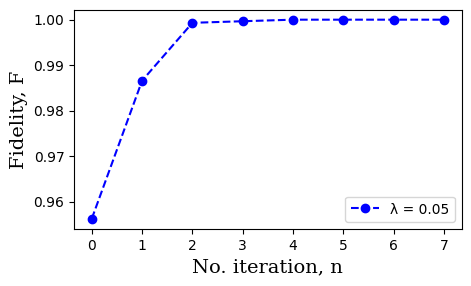

In [61]:
noq = 3
lam = 0.05
GHZ = make_GHZ(noq)
GHZl = make_GHZl(noq, 1.1)
rho_GHZ = make_rho_GHZ(GHZ)
rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)

noi = 8 #No. iteration
iter_data = list(range(noi))
fid_data = [fidelity(alternating_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]
#fid_data = [fidelity(uniform_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]

xfont = {'fontname':'serif'}

f = plt.figure(figsize=(5,3))
plt.plot(iter_data[0::1], fid_data[0::1], 'o--b', label='λ = ' + str(lam))
plt.xlabel('No. iteration, n', **xfont)
plt.ylabel('Fidelity, F', **xfont)
#plt.title('Noisy GHZ')
plt.legend()
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#plt.savefig('uniform-iter.pdf')
#files.download("uniform-iter.pdf")
plt.show()

In [115]:
protocol_list = []

noq = 3 #No. qubits
noi = 10 #No. iteration
iter_data = list(range(noi))
GHZ = make_GHZ(noq)
rho_GHZ = make_rho_GHZ(GHZ)
for lam in np.arange(0.0, 1.2, 0.2):
  rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)
  #fid_data = [fidelity(alternating_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]  #Alternating scheme
  fid_data = [fidelity(uniform_trained(rho_noisy, noq, i), GHZ) for i in range(noi)]        #Uniform scheme -> doesnt work well??
  protocol_list += [fid_data]

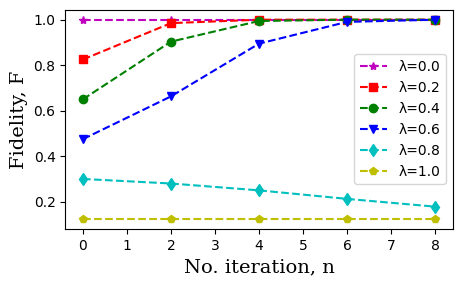

In [116]:
from google.colab import files

xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data[0::2], protocol_list[0][0::2], '*--m', label='λ=0.0')
ax.plot(iter_data[0::2], protocol_list[1][0::2], 's--r', label='λ=0.2')
ax.plot(iter_data[0::2], protocol_list[2][0::2], 'o--g', label='λ=0.4')
ax.plot(iter_data[0::2], protocol_list[3][0::2], 'v--b', label='λ=0.6')
ax.plot(iter_data[0::2], protocol_list[4][0::2], 'd--c', label='λ=0.8')
ax.plot(iter_data[0::2], protocol_list[5][0::2], 'p--y', label='λ=1.0')
ax.legend()
ax.set_xlabel('No. iteration, n', **xfont)
ax.set_ylabel('Fidelity, F', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#fig.savefig('uniλ.pdf')
#files.download("uniλ.pdf")
plt.show()

**Alternating double iteration protocol for N-qubit:** <br>
*conclusion:* this scheme can be easily adopted to arbitrary number of qubits (parties)

In [ ]:
protocol_list += [fid_data]

In [ ]:
len(protocol_list)

5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

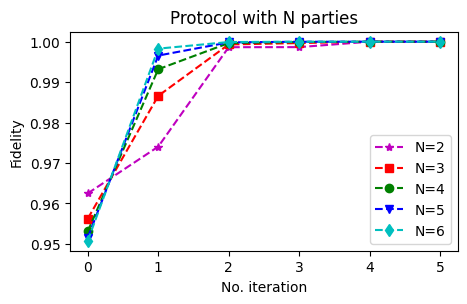

In [ ]:
from google.colab import files

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data, protocol_list[0], '*--m', label='N=2')
ax.plot(iter_data, protocol_list[1], 's--r', label='N=3')
ax.plot(iter_data, protocol_list[2], 'o--g', label='N=4')
ax.plot(iter_data, protocol_list[3], 'v--b', label='N=5')
ax.plot(iter_data, protocol_list[4], 'd--c', label='N=6')
ax.legend()
ax.set_xlabel('No. iteration')
ax.set_ylabel('Fidelity')
ax.set_title('Protocol with N parties')
# alternate option without .gcf
plt.subplots_adjust(bottom=0.15)
#fig.savefig('nparty.png')
#files.download("nparty.png")
plt.show()

**Uniform pre-trained protocol for N-qubit:** <br>
*conclusion:* this scheme cannot be extended for arbitrary number of qubits (parties)

In [94]:
noq = 5
lam = 0.3
GHZ = make_GHZ(noq)
rho_GHZ = make_rho_GHZ(GHZ)
rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)

noi = 8 #No. iteration
iter_data = list(range(noi))
fid_data = [fidelity(alternating_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]
#fid_data = [fidelity(uniform_trained(rho_noisy, noq, i), GHZ) for i in range(noi)]

In [90]:
protocol_list = []

In [95]:
protocol_list += [fid_data]

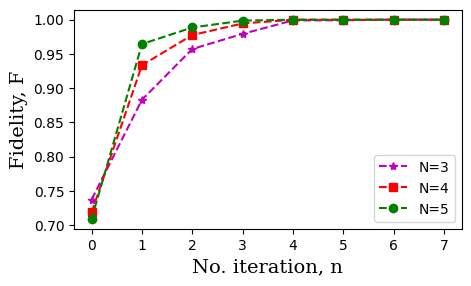

In [96]:
xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
#ax.plot(iter_data[0::2], protocol_list[0][0::2], '*--m', label='N=3')
#ax.plot(iter_data[0::2], protocol_list[1][0::2], 's--r', label='N=4')
#ax.plot(iter_data[0::2], protocol_list[2][0::2], 'o--g', label='N=5')
#ax.plot(iter_data[0::2], protocol_list[3][0::2], 'v--b', label='N=2')

ax.plot(iter_data, protocol_list[0], '*--m', label='N=3')
ax.plot(iter_data, protocol_list[1], 's--r', label='N=4')
ax.plot(iter_data, protocol_list[2], 'o--g', label='N=5')
#ax.plot(iter_data, protocol_list[3], 'v--b', label='N=2')

ax.legend()
ax.set_xlabel('No. iteration, n', **xfont)
ax.set_ylabel('Fidelity, F', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#fig.savefig('uniλ.pdf')
#files.download("uniλ.pdf")
plt.show()

**Uniform simplified protocol for N-qubit:** <br>
*conclusion:* this scheme can be extended for arbitrary number of qubits (parties)

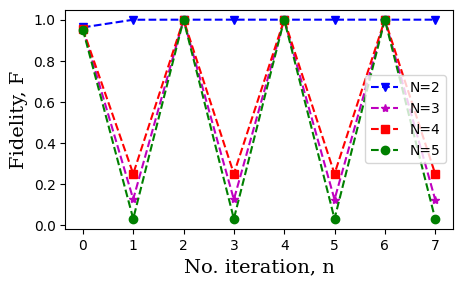

In [ ]:
xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
#ax.plot(iter_data[0::2], protocol_list[0][0::2], '*--m', label='N=3')
#ax.plot(iter_data[0::2], protocol_list[1][0::2], 's--r', label='N=4')
#ax.plot(iter_data[0::2], protocol_list[2][0::2], 'o--g', label='N=5')
#ax.plot(iter_data[0::2], protocol_list[3][0::2], 'v--b', label='N=2')

ax.plot(iter_data, protocol_list[0], 'v--b', label='N=2')
ax.plot(iter_data, protocol_list[1], '*--m', label='N=3')
ax.plot(iter_data, protocol_list[2], 's--r', label='N=4')
ax.plot(iter_data, protocol_list[3], 'o--g', label='N=5')


ax.legend()
ax.set_xlabel('No. iteration, n', **xfont)
ax.set_ylabel('Fidelity, F', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#fig.savefig('uniλ.pdf')
#files.download("uniλ.pdf")
plt.show()